# <center> Stroke Prediction - Final Notebook
## <center> Notebook Overview
Here be the overview of what this notebook entails.

## <center> Executive Summary
Here be the executive summary of the work done in this notebook.
    
## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split

import prepare
import model

# <center> 1. Wrangle
## Wrangle Overview
1. Acquired dataset from Kaggle
1. Dropped outliers in BMI and gender columns
1. Renamed columns, cast columns to appropriate data types, dropped unnecessary columns
1. Imputed nulls in BMI column using average BMI for age range and gender
1. Plotted univariate distributions to check work
1. Noticed class imbalance and need for SMOTE+Tomek resampling
1. Encoded categorical columns identified from univariate distributions
1. Converted ordinal values from 1s and 0s to True and False values from univariate distributions
1. Created bmi_range column for BMI grouping from univariate distributions
1. Created high_glucose feature based on Explore analysis
1. Created is_senior feature based on Explore analysis
1. Split data into Train, Validate, and Test splits

## Cleaning the Data
First up, we need to clean the dataset for exploration. The specific steps are described above. These steps were put to a function in prepare.py, which we call in the following cell.

In [2]:
# Use the prep_data function to prepare the data
df = prepare.prep_data(pd.read_csv('healthcare-dataset-stroke-data.csv'))

# Check results
print(f'Shape: {df.shape[0]} rows, {df.shape[1]} columns.')
df.head(3)

Shape: 5107 rows, 12 columns.


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_range
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65-70
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.6,never smoked,1,60-65
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,75-80


## Univariate Distribution Plots
Here, we will check to make sure our distributions look okay. 

------------------------------   gender   ------------------------------


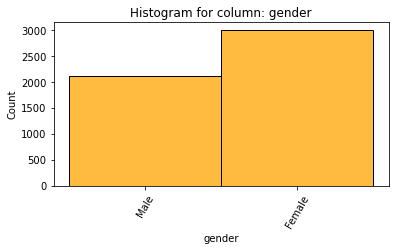

------------------------------   age   ------------------------------


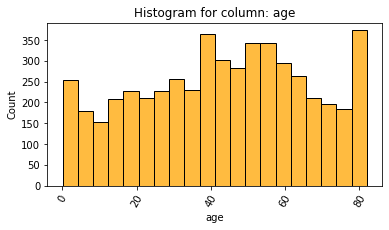

------------------------------   hypertension   ------------------------------


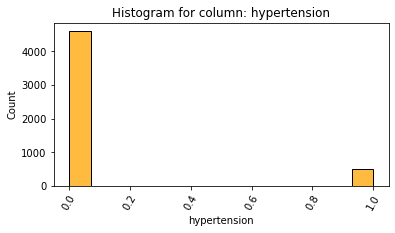

------------------------------   heart_disease   ------------------------------


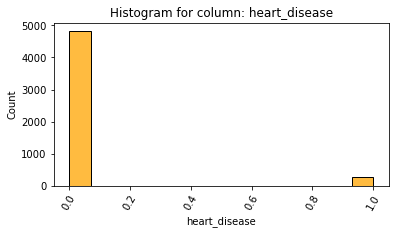

------------------------------   ever_married   ------------------------------


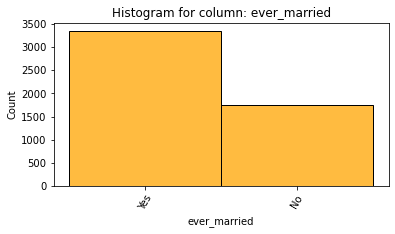

------------------------------   work_type   ------------------------------


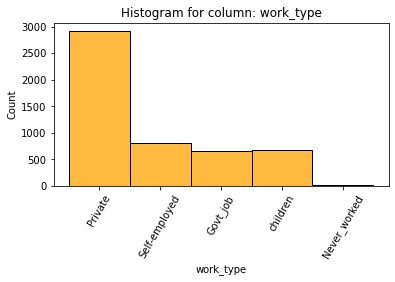

------------------------------   residence_type   ------------------------------


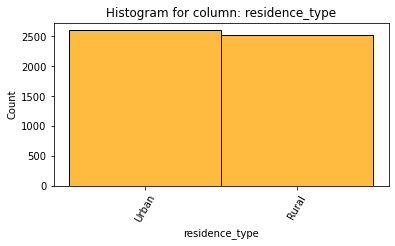

------------------------------   avg_glucose_level   ------------------------------


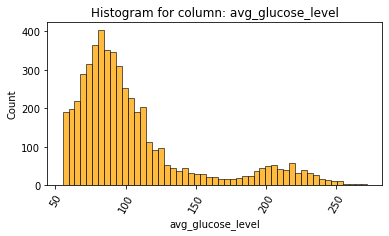

------------------------------   bmi   ------------------------------


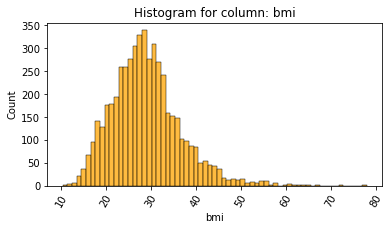

------------------------------   smoking_status   ------------------------------


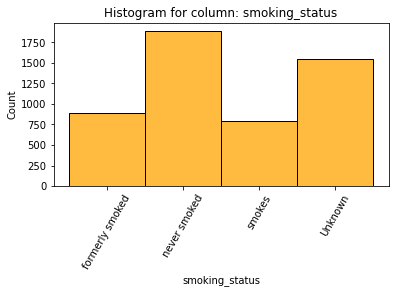

------------------------------   stroke   ------------------------------


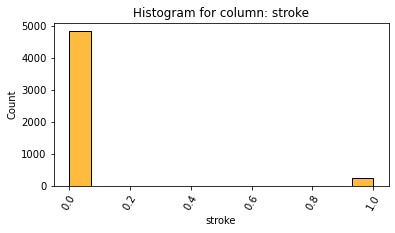

------------------------------   age_range   ------------------------------


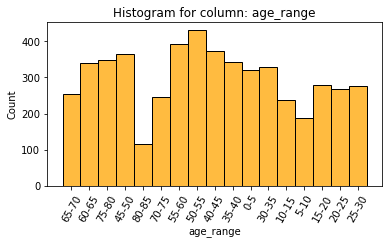

In [3]:
# Plot univariate distributions for each column
for col in df.columns:
    plt.figure(figsize=(6,3))
    print('-'*30, ' ', col, ' ', '-'*30) # use a line separator charts
    sns.histplot(df[col], color='orange')
    plt.title('Histogram for column: ' + col)
    plt.xticks(rotation=60)
    plt.show()

## Need for SMOTE + Tomek Oversampling
Our target is imbalanced, as can be seen below. We will need to use SMOTE + Tomek Oversampling later on in the Modeling section to train our classification models with balanced classes.

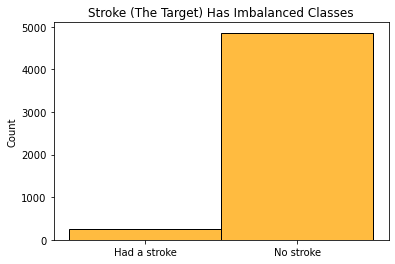

In [4]:
# Plot histogram showing class imbalance in 'stroke' column
sns.histplot(np.where(df.stroke == 1, 'Had a stroke', 'No stroke'), color='orange')
plt.title('Stroke (The Target) Has Imbalanced Classes')
plt.show()

## Feature Engineering
From these univariate distributions, we've decided to modify some features for exploration purposes. We've also incorporated some feature engineering based on analysis done in the Explore stage. This work is captured by the engineer_features function in prepare.py. 

Note: *We've combined the 'children' work type and the 'Never_worked' work type because there was overlap for those under 18 years old having the latter work type.* All other features are simply encoded or have additional columns with categorization.

In [5]:
# engineer features
engineered_df = prepare.engineer_features(df)

Original shape: 5107 rows, 12 columns.
New shape: 5107 rows, 21 columns.


In [6]:
# check results
engineered_df.head(3)

,stroke,age,age_range,is_senior,bmi,bmi_range,avg_glucose_level,high_glucose,has_hypertension,has_heart_disease,...,is_female,is_urban,smoking_status,current_smoker,prior_smoker,never_smoked,govt_job,self_employed,private_work,never_worked
0,1,67.0,65-70,True,36.6,30-39,228.69,True,False,True,...,False,True,formerly smoked,False,True,False,False,False,True,False
1,1,61.0,60-65,True,30.6,30-39,202.21,True,False,False,...,True,False,never smoked,False,False,True,False,True,False,False
2,1,80.0,75-80,True,32.5,30-39,105.92,False,False,True,...,False,False,never smoked,False,False,True,False,False,True,False


## Split data for Exploration
In order to explore on in-sample data, we will split our dataset into in-sample data and out-of-sample data. We will use the two out-of-sample splits for modeling purposes. Our splits are 60% in-sample and 20% for each out-of-sample split.

In [7]:
# Split data 60-20-20 into Train, Validate, and Test splits
train_validate, test = train_test_split(engineered_df, test_size=0.2, random_state=777)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=777)

print(f'Train shape: {train.shape}, Validate shape: {validate.shape}, Test shape: {test.shape}')
print('Row count of original dataset:', df.shape[0])
print('Row count of combined data splits:', train.shape[0] + validate.shape[0] + test.shape[0])

Train shape: (3063, 21), Validate shape: (1022, 21), Test shape: (1022, 21)
Row count of original dataset: 5107
Row count of combined data splits: 5107


## Wrangle Summary
- Cleaned the dataset
- Checked distributions, noticed class imbalance
- Engineered features in preparation for exploration
- Split data

# <center>2. Explore
## Exploration Overview
1. Checked distributions against the target, 'stroke'
1. Tested initial hypotheses
1. 

## Initial Hypotheses
### Hypothesis 1: There is relationship between average glucose level and BMI.
> - $H_0$ : There is no relationship between average glucose level and BMI.
> - $H_a$ : There is relationship between average glucose level and BMI.
> - Confidence interval is 95%

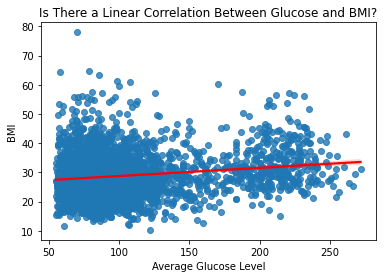

In [8]:
# visualize: use regression plot to check linear trend
sns.regplot(data=train, x="avg_glucose_level", y="bmi", line_kws={'color': 'red'})
plt.title('Is There a Linear Correlation Between Glucose and BMI?')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.show()

In [9]:
# test: set alpha for test
alpha = .05
# conduct pearson r test 
corr, p = stats.pearsonr(train.avg_glucose_level, train.bmi)
# output results
if p < alpha:
    print('We are 95% confident that there is a relationship between average glucose level and BMI.')
else:
    print('We can not say with 95% confidence that there is a realionship between average glucose level and BMI.')

We are 95% confident that there is a relationship between average glucose level and BMI.


### Hypothesis 2: People over 65 years old are more likely to have a stroke than people under 65.
> - $H_0$ : People over 65 years old are not more likely to have a stroke than people under 65.
> - $H_a$ : People over 65 years old are more likely to have a stroke than people under 65.
> - Confidence interval is 95%

In [10]:
# prepare: create samples based on age over or under 65
over_65 = train[train['age'] >= 65]
under_65 = train[train['age'] < 65]
train['over_65'] = np.where(train['age'] >= 65, "Over 65", "Under 65")

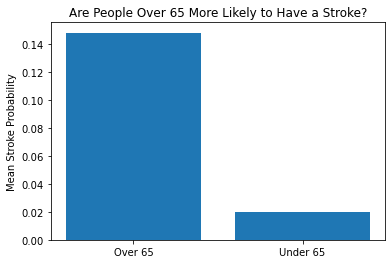

In [11]:
# visualize: plot sample means for stroke
heights = [round(over_65.stroke.mean(), 3), round(under_65.stroke.mean(), 3)]
x_labels = ['Over 65', 'Under 65']
plt.bar(x=x_labels, height=heights)
plt.title('Are People Over 65 More Likely to Have a Stroke?')
plt.ylabel("Mean Stroke Probability")
plt.show()

In [12]:
# test: set alpha
alpha = .05
# conduct chi2 contingency test
age_65_crosstab = pd.crosstab(train['over_65'], train['stroke'], normalize='index')
_, p, _, contigency_pct = stats.chi2_contingency(age_65_crosstab)
cont_df = pd.DataFrame(contigency_pct, 
                       columns=['Had Stroke','No Stroke'], 
                       index=['Over 65','Under 65'])
# output results
if p < alpha:
    print('We are 95% confident that people over 65 years old are more likely to have a stroke than people under 65.')
else:
    print('We can not say with 95% confidence that people over 65 years old are not more likely to have a stroke than people under 65.')

We are 95% confident that people over 65 years old are more likely to have a stroke than people under 65.


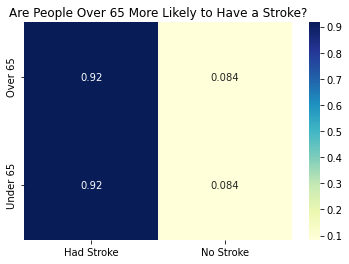

In [13]:
# heatmap viz
plt.figure(figsize=(6,4))
sns.heatmap(cont_df, annot=True, cmap="YlGnBu")
plt.title('Are People Over 65 More Likely to Have a Stroke?')
plt.show()

### Hypothesis 3: People that currently smoke have a higher risk of stroke than people that don’t currently smoke.
> - $H_0$ : People that currently smoke do not have a higher risk of stroke than people that don’t currently smoke.
> - $H_a$ : People that currently smoke have a higher risk of stroke than people that don’t currently smoke.
> - Confidence interval is 95%

In [14]:
know_smoking_status = train[train.smoking_status != 'Unknown']
know_smoking_status['current_smoker'] = know_smoking_status.smoking_status == 'smokes'

In [15]:
# test: set alpha
alpha = .05
# run chi2 contingency test
smoker_crosstab = know_smoking_status.groupby('current_smoker').stroke.value_counts().unstack()
total_count = smoker_crosstab.sum().sum()
smoker_crosstab = smoker_crosstab.apply(lambda x: 100 * x / float(total_count))

_, p, _, smoker_cont_pct = stats.chi2_contingency(smoker_crosstab)
cont_df = pd.DataFrame(smoker_cont_pct, 
                       columns=['Had Stroke','No Stroke'], 
                       index=['Currently Smoking', 'Not Currently Smoking'])

# output results
if p < alpha:
    print('People that currently smoke have a higher risk of stroke than people that don’t currently smoke.')
else:
    print('We can not say with 95% confidence that people who currently smoke have a higher risk of stroke than people who don’t currently smoke.')

We can not say with 95% confidence that people who currently smoke have a higher risk of stroke than people who don’t currently smoke.


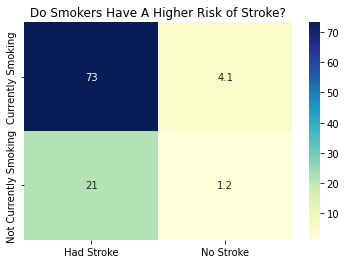

In [16]:
# heatmap viz
plt.figure(figsize=(6,4))
sns.heatmap(cont_df, annot=True, cmap="YlGnBu")
plt.title('Do Smokers Have A Higher Risk of Stroke?')
plt.show()

In [17]:

cont_df
# # output results
# if p < alpha and t > 0:
#     print('People that currently smoke have a higher risk of stroke than people that don’t currently smoke.')
# else:
#     print('We can not say with 95% confidence that people who currently smoke have a higher risk of stroke than people who don’t currently smoke.')

,Had Stroke,No Stroke
Currently Smoking,73.227291,4.096129
Not Currently Smoking,21.475311,1.201269


In [18]:
train.columns

Index(['stroke', 'age', 'age_range', 'is_senior', 'bmi', 'bmi_range',
       'avg_glucose_level', 'high_glucose', 'has_hypertension',
       'has_heart_disease', 'ever_married', 'is_female', 'is_urban',
       'smoking_status', 'current_smoker', 'prior_smoker', 'never_smoked',
       'govt_job', 'self_employed', 'private_work', 'never_worked', 'over_65'],
      dtype='object')

### Hypothesis 4: Men are more at risk for stroke than women.
> - $H_0$ : Men are not more at risk for stroke than women.
> - $H_a$ : Men are more at risk for stroke than women.
> - Confidence interval is 95%

In [19]:
# prepare: create samples for men and women
men = train[train.is_female == "False"]
women = train[train.is_female == "True"]

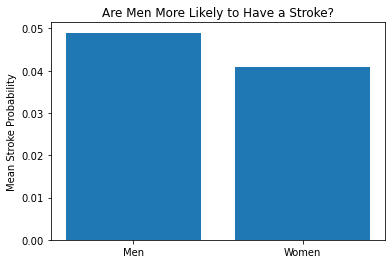

In [20]:
# visualize: plot sample means for stroke
heights = [round(men.stroke.mean(), 3), round(women.stroke.mean(), 3)]
x_labels = ['Men', 'Women']
plt.bar(x=x_labels, height=heights)
plt.title('Are Men More Likely to Have a Stroke?')
plt.ylabel("Mean Stroke Probability")
plt.show()

In [21]:
# test: set alpha
alpha = .05
# run mannwhitney u test
t, p = stats.mannwhitneyu(men.stroke, women.stroke, alternative='greater')
# output results
if p < alpha and t > 0:
    print('We are 95% confident that men are more at risk for stroke than women.')
else:
    print('We can not say with 95% confidence that men are more at risk for stroke than women.')

We can not say with 95% confidence that men are more at risk for stroke than women.


### Initial Hypotheses - Combined Results
> #### We are 95% confident that there is a relationship between average glucose level and BMI.
> #### We are 95% confident that people over 65 years old are more likely to have a stroke than people under 65.
> #### We can not say with 95% confidence that people who currently smoke have a higher risk of stroke than people who don’t currently smoke.
> #### We can not say with 95% confidence that men are more at risk for stroke than women.

# Further Exploration
## Stats Tests - from combination of team members' notebook work
* Explain statistical tests to check if features are driving stroke occurence
* Independence (Chi2) tests between features and target
* T-Tests to check drivers
* Sample vizs to explain process
* Actual vizs on their own (limiting redundancy of explanation)

## Initial Bivariate Visualizations
* Show how age is distributed differently between had_stroke and no_stroke
    * Explain potential effect of age column on other features

-------------------- age --------------------


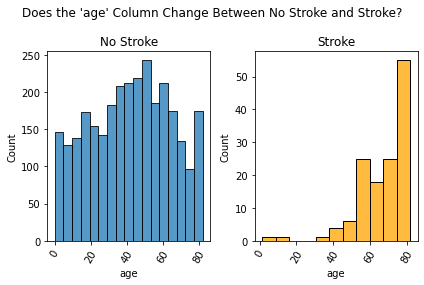

Mean value of age between had-stroke and no-stroke is significantly different.

-------------------- is_senior --------------------


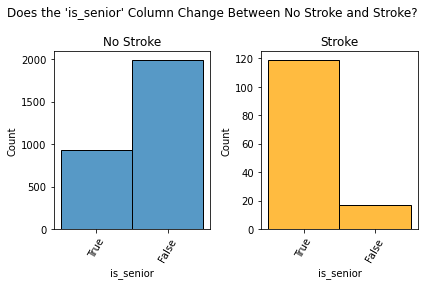

Mean value of is_senior between had-stroke and no-stroke is significantly different.

-------------------- bmi --------------------


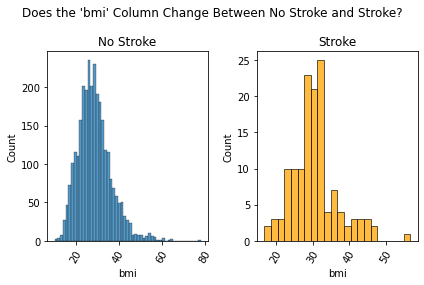

Mean value of bmi between had-stroke and no-stroke is significantly different.

-------------------- avg_glucose_level --------------------


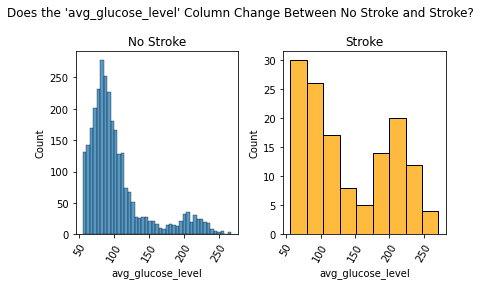

Mean value of avg_glucose_level between had-stroke and no-stroke is significantly different.

-------------------- high_glucose --------------------


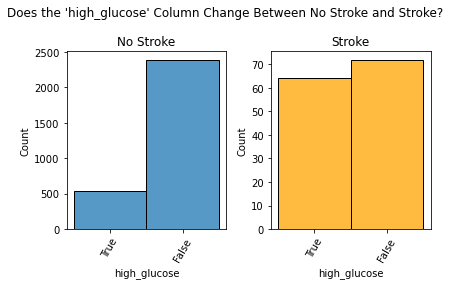

Mean value of high_glucose between had-stroke and no-stroke is significantly different.

-------------------- has_hypertension --------------------


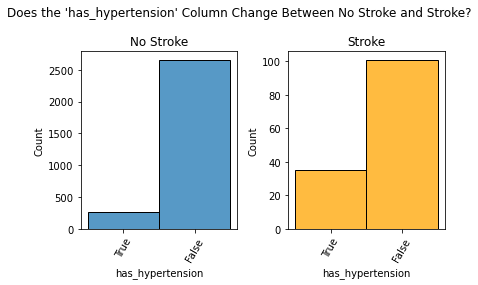

Mean value of has_hypertension between had-stroke and no-stroke is significantly different.

-------------------- has_heart_disease --------------------


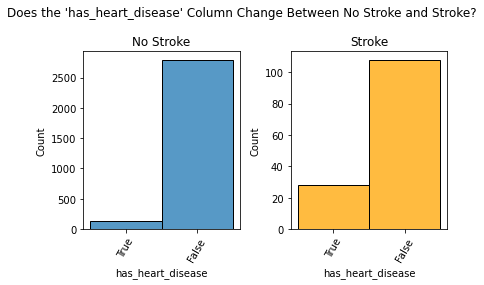

Mean value of has_heart_disease between had-stroke and no-stroke is significantly different.

-------------------- ever_married --------------------


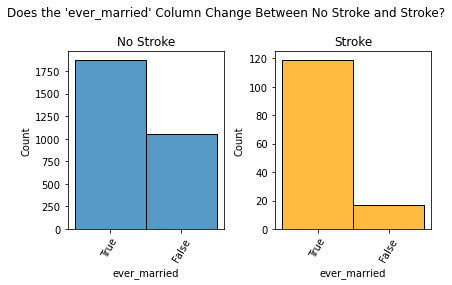

Mean value of ever_married between had-stroke and no-stroke is significantly different.

-------------------- is_female --------------------


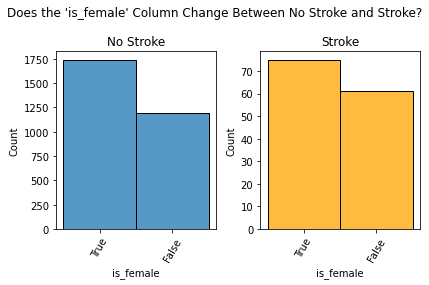

Mean value of is_female between had-stroke and no-stroke is not significantly different.

-------------------- is_urban --------------------


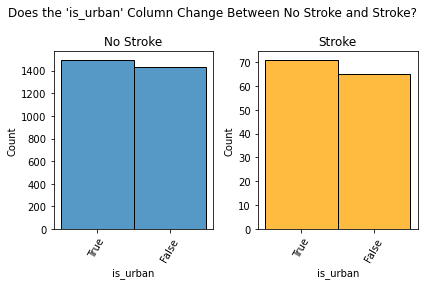

Mean value of is_urban between had-stroke and no-stroke is not significantly different.

-------------------- smoking_status --------------------


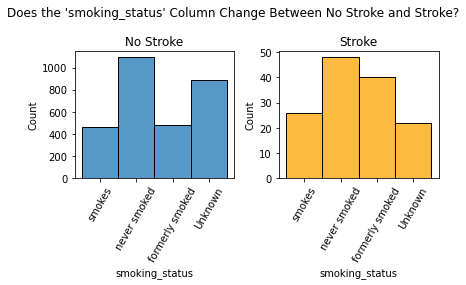

Mean value of smoking_status between had-stroke and no-stroke is not significantly different.

-------------------- current_smoker --------------------


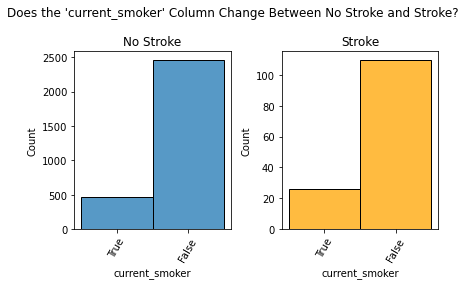

Mean value of current_smoker between had-stroke and no-stroke is not significantly different.

-------------------- prior_smoker --------------------


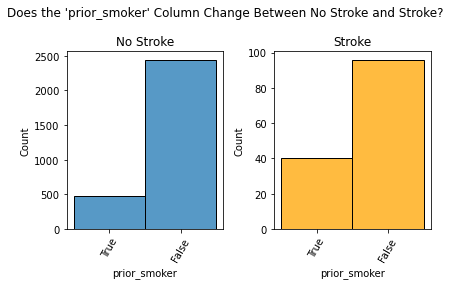

Mean value of prior_smoker between had-stroke and no-stroke is significantly different.

-------------------- never_smoked --------------------


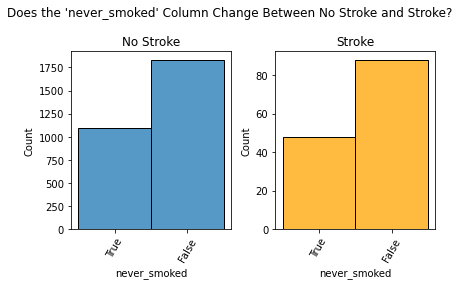

Mean value of never_smoked between had-stroke and no-stroke is not significantly different.

-------------------- govt_job --------------------


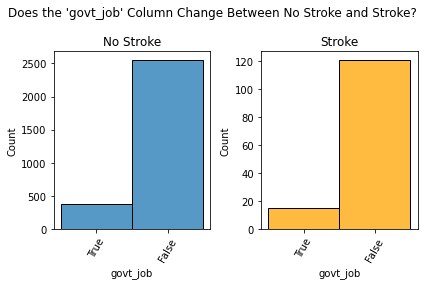

Mean value of govt_job between had-stroke and no-stroke is not significantly different.

-------------------- self_employed --------------------


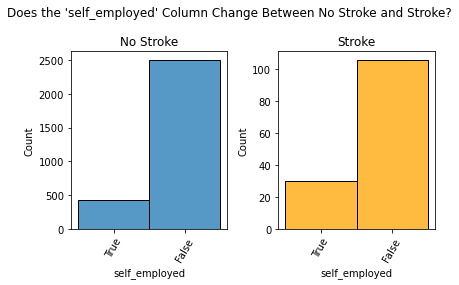

Mean value of self_employed between had-stroke and no-stroke is significantly different.

-------------------- private_work --------------------


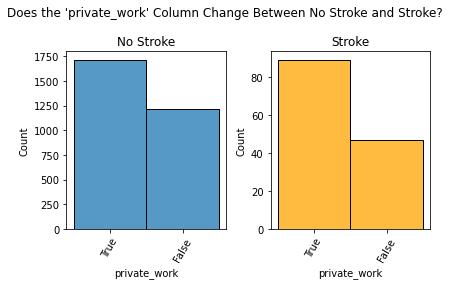

Mean value of private_work between had-stroke and no-stroke is not significantly different.

-------------------- never_worked --------------------


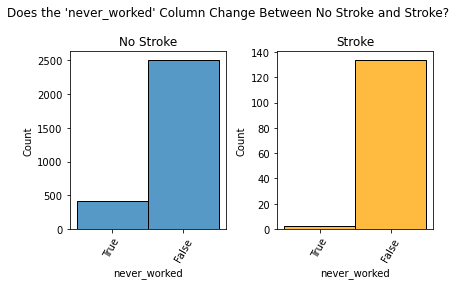

Mean value of never_worked between had-stroke and no-stroke is significantly different.

-------------------- over_65 --------------------


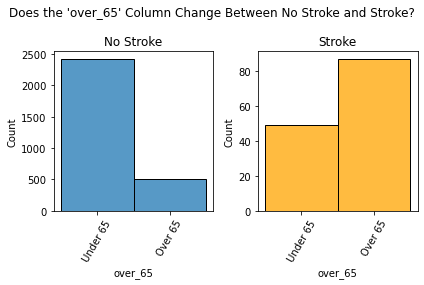

Mean value of over_65 between had-stroke and no-stroke is significantly different.



In [22]:
# initial chart look (looking for differences between left chart and right chart for each)
col_list_to_drop = ['age_range','bmi_range']
for col in train.drop(columns=col_list_to_drop).columns[1:]:
    print('-'*20, col, '-'*20)
    # visualization
    plt.subplot(121) # Observations without stroke (left charts)
    plt.title('No Stroke')
    sns.histplot(train[train.stroke == 0][col].sort_values(ascending=False))
    plt.xticks(rotation=60)
    plt.subplot(122) # Observations with stroke (right charts)
    plt.title('Stroke')
    sns.histplot(train[train.stroke == 1][col].sort_values(ascending=False), color='orange')
    plt.xticks(rotation=60)
    plt.suptitle("Does the '" + col + "' Column Change Between No Stroke and Stroke?")
    plt.tight_layout()
    plt.show()
    # statistical test
    t, p = stats.mannwhitneyu(train[train.stroke == 1][col], 
                              train[train.stroke == 0][col],
                              alternative='two-sided')
    if t != 0 and p < .025:
        print(f"Mean value of {col} between had-stroke and no-stroke is significantly different.")
        print('')
    else:
        print(f"Mean value of {col} between had-stroke and no-stroke is not significantly different.")
        print('')

## Results of Bivariate Visualizations
Keepers:
- age
- is_senior
- bmi
- avg_glucose_level
- high_glucose
- has_hypertension
- has_heart_disease
- prior_smoker
- self_employed
- never_worked

Remove:
- is_female
- is_urban
- current_smoker
- never_smoked
- govt_job
- private_work

In [23]:
train = train.drop(columns=['is_female','is_urban','current_smoker','never_smoked',
                            'govt_job','private_work'])

## Age May Drive Other Features
The 'age' column has a significant difference in distribution between no-stroke and stroke. The team suspects that **age may be driving stroke occurence and also driving other features.** It's possible that some features may not drive stroke occurence- only appear to do so because they are being driven by age, which (likely) is driving stroke.

Here is a visualization showing the difference in distribution for the age column.

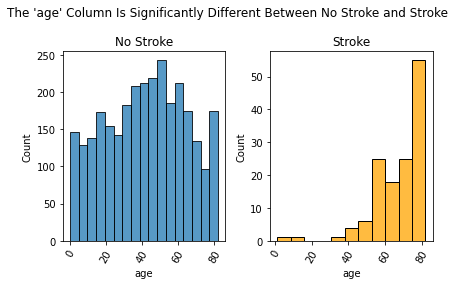

In [24]:
# show the difference in distribution for age between no stroke and stroke
plt.subplot(121) # Observations without stroke (left charts)
plt.title('No Stroke')
sns.histplot(train[train.stroke == 0]['age'].sort_values(ascending=False))
plt.xticks(rotation=60)
plt.subplot(122) # Observations with stroke (right charts)
plt.title('Stroke')
sns.histplot(train[train.stroke == 1]['age'].sort_values(ascending=False), color='orange')
plt.xticks(rotation=60)
plt.suptitle("The 'age' Column Is Significantly Different Between No Stroke and Stroke")
plt.tight_layout()
plt.show()

## Determining if Age Matters for a Feature - Categorical
### Visual Determination
To check visually if features differ regardless of age, we will use the feature 'is_senior' to split the data into two samples, then check the feature's stroke risk for its values. The implementation is in the following charts.

We're looking to see if the orange columns are both higher than the blue columns they're associated with.

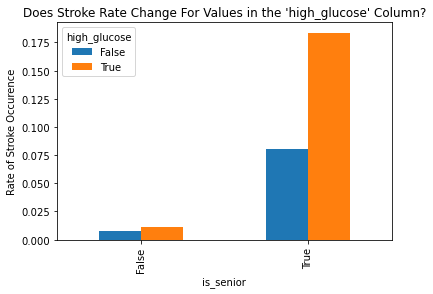

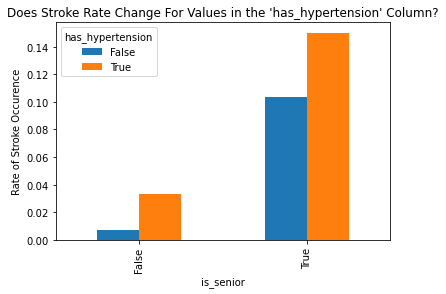

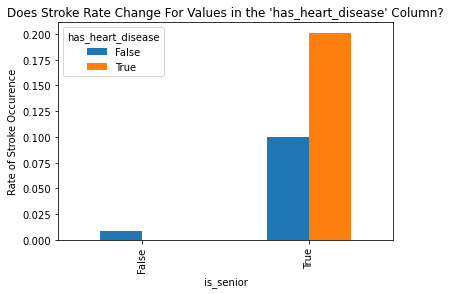

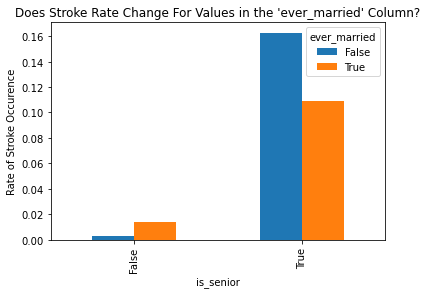

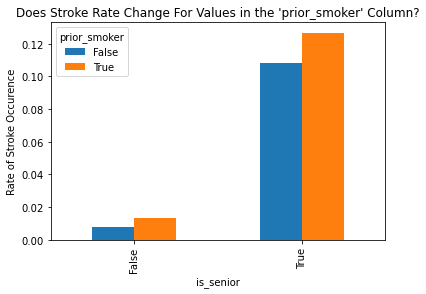

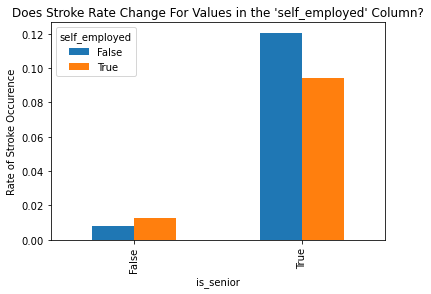

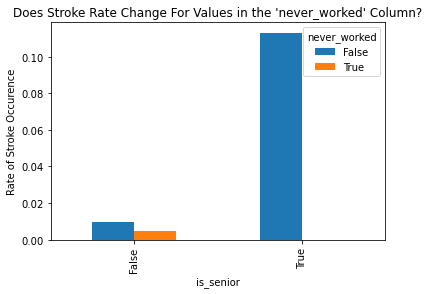

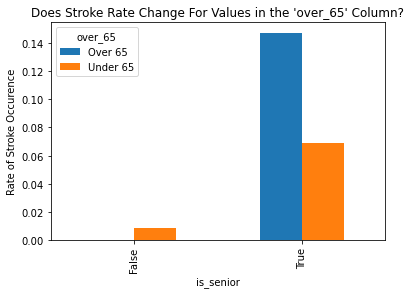

In [25]:
for col in train.drop(columns='smoking_status').columns[7:]:
    train.groupby(['is_senior',col]).stroke.mean().unstack().plot.bar()
    plt.title("Does Stroke Rate Change For Values in the '" + col + "' Column?")
    plt.ylabel('Rate of Stroke Occurence')
    plt.show()

### Visual Determination Results
- **high_glucose** increases risk of stroke (orange bars larger than blue bars), but the increase for seniors is larger, suggesting age has an influence
- **has_hypertension** increases risk of stroke (orange bars larger than blue bars), but the increase for seniors is less dramatic, suggesting younger prople with hypertension are more at risk than older
- **has_heart_disease** entirely belongs to those over age 55, suggesting it has everything to do with age.
- **ever_married** indicates a higher risk for people under 55, but a lower risk for people over 55, for those who have ever married.
- **prior_smoker** increases risk of stroke (orange bars larger than blue bars), and the increase is similar for those under or over 55, suggesting age does not have an influence.
- **self_employed** indicates a higher risk for people under 55, but a lower risk for people over 55, for those who are self employed.
- **never_worked** entirely belongs to those under age 55, suggesting it has more to do with age.

### Statistical Determination
Using the under-55 and over-55 splits, we will run chi2 tests between stroke and a feature on one split, then run it on another split. The goal is to find if a feature is dependent for both tests.

In [26]:
# set alpha
alpha = .05
# create over-55 and under-55 samples
over_55 = train[train.age >= 55]
under_55 = train[train.age < 55]

In [27]:
# create helper function to print results
def double_independence(p1, p2, alpha):
    """ 
        Compares p-values for Stroke and a feature for Stroke Prediction dataset, 
        Prints results.
    """
    if p1 < alpha:
        if p2 < alpha:
            print(f'{col} and stroke are dependent for both age samples.')
        else:
            print(f'{col} and stroke are dependent for over-55, independent for under-55.')
    else:
        if p2 < alpha:
            print(f'{col} and stroke are independent for over-55, dependent for under-55.')
        else:
            print(f'{col} and stroke are independent for both age samples.')
    
    print('')

In [28]:
# iterate through categorical columns
for col in train.drop(columns='smoking_status').columns[7:]:
    # create crosstabs for stroke and a column for each sample
    over_55_crosstab = pd.crosstab(over_55['stroke'], over_55[col])
    under_55_crosstab = pd.crosstab(under_55['stroke'], under_55[col])
    # run chi2 tests for each sample on stroke and a column
    chi2_over55, p_over55,\
    degf_over55, expected_over55 = stats.chi2_contingency(over_55_crosstab)
    chi2_under55, p_under55,\
    degf_under55, expected_under55 = stats.chi2_contingency(under_55_crosstab)
    # print results
    double_independence(p_over55, p_under55, alpha)

high_glucose and stroke are dependent for over-55, independent for under-55.

has_hypertension and stroke are independent for over-55, dependent for under-55.

has_heart_disease and stroke are dependent for over-55, independent for under-55.

ever_married and stroke are independent for over-55, dependent for under-55.

prior_smoker and stroke are independent for both age samples.

self_employed and stroke are independent for both age samples.

never_worked and stroke are independent for both age samples.

over_65 and stroke are dependent for over-55, independent for under-55.



### Combined Results
**Dependent for one age sample (driving stroke):**
1. **high_glucose** and stroke are **dependent for over-55**, independent for under-55.
1. **has_hypertension** and stroke are independent for over-55, **dependent for under-55**.
1. **has_heart_disease** and stroke are **dependent for over-55**, independent for under-55.
1. **ever_married** and stroke are independent for over-55, **dependent for under-55**.

**Independent on both age samples (not driving stroke):**
1. **prior_smoker** and stroke are **independent for both** age samples.
1. **self_employed** and stroke are **independent for both** age samples.
1. **never_worked** and stroke are **independent for both** age samples.

# Exploration Takeaways
Based on our analysis, these features are associated with stroke risk:
1. Having high glucose level (hyperglycemia)
    * Can cause damage to blood cells, resulting in clotting, and stroke
2. Having hypertension
    * Can damage vein walls, causing repairs and clotting, and stroke
3. Having had, or have, heart disease
    * Cardiovascular issues may lead to clotting, and stroke
4. Having been, or currently, married
    * Requires further exploration

# <center> 3. Model
## a. Modeling Overview
- Encoded features that need it
- Isolated target
- Applied SMOTE + Tomek oversampling to train models on balanced classes
- Built, fit multiple classification models
- Evaluated results of all models on Validate split
- Chose best model to evaluate on Test split
- Evaluated best model on Test split

## b. Building, Fitting, Evaluating Models
### Model Preparation Script - Only Explore-Derived Features - No SMOTE

In [29]:
# use prepare.model_prep__no_smote function here
X_train_no_smote, y_train_no_smote,\
X_validate_no_smote, y_validate_no_smote,\
X_test_no_smote, y_test = prepare.post_analysis_model_prep_no_oversample()

### Model Build+Fit+Predict Script - Only Explore-Derived Features - No SMOTE
- Return non-SMOTEd predictions dataframe, keep separate

In [30]:
# use model.classification_shotgun function here to build predictions dataframe (non-SMOTEd)
no_smote_predictions_train,\
no_smote_predictions_validate = model.classification_shotgun(X_train_no_smote, 
                                                             y_train_no_smote, 
                                                             X_validate_no_smote, 
                                                             y_validate_no_smote)

### Model Preparation Script - Only Explore-Derived Features - with SMOTE

In [31]:
# use SMOTE on the train split here - don't use the model_prep function
X_train, y_train,\
X_validate, y_validate,\
X_test, y_test = prepare.post_analysis_model_prep()

Before SMOTE applied: (3066, 7) (3066,)
After SMOTE applied: (5324, 7) (5324,)


### Model Build+Fit+Predict Script - Only Explore-Derived Features - with SMOTE
- Return SMOTEd predictions dataframe, keep separate

In [32]:
# use model.classification_shotgun function here to build predictions dataframe on SMOTEd data
smote_predictions_train,\
smote_predictions_validate = model.classification_shotgun(X_train, y_train,
                                                          X_validate, y_validate)

### Model Preparation Script - All Features - with SMOTE

In [33]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [34]:
df = prepare.prep_data(df)

In [35]:
X_train_all, y_train_all,\
X_validate_all, y_validate_all,\
X_test_all, y_test_all = prepare.model_prep(df)

Before SMOTE applied: (3063, 31) (3063,)
After SMOTE applied: (5832, 31) (5832,)


### Model Build+Fit+Predict Script - All Features - with SMOTE

In [36]:
all_vars_smote_predictions_train,\
all_vars_smote_predictions_validate = model.classification_shotgun(X_train_all, y_train_all,
                                                                   X_validate_all, y_validate_all)

## c. Model Performance on Train, Validate
### Model Evaluation Script - Comparing non-SMOTEd and SMOTEd Models
- Join the non-SMOTEd and SMOTEd dataframes together with column renaming to identify if model incorporated SMOTE or not
- Print evaluation results of joined dataframe as normal
- Show difference between SMOTEd and non-SMOTEd model performance

## Only Explore-Derived Features - without SMOTE - Model Performances

In [37]:
# use model.print_classification_results function here to check results of all models
print('Only Explore-Derived Features - without SMOTE - Model Performances')
model.print_classification_results(no_smote_predictions_train, no_smote_predictions_validate)\
.sort_values(by='OutSample_Recall', ascending=False).head(7)

Only Explore-Derived Features - without SMOTE - Model Performances


,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall
13,nb_vsmooth1e-08,0.8607,0.8493,0.3793,0.40
12,nb_vsmooth1e-09,0.8607,0.8493,0.3793,0.40
15,nb_vsmooth1e-06,0.8607,0.8493,0.3793,0.40
14,nb_vsmooth1e-07,0.8607,0.8493,0.3793,0.40
16,nb_vsmooth1e-05,0.8611,0.8493,0.3862,0.40
17,nb_vsmooth0.0001,0.9318,0.9217,0.2000,0.10
10,rf_depth10,0.9710,0.9374,0.3862,0.08


## Only Explore-Derived Features - with SMOTE - Model Performances

In [38]:
print('Only Explore-Derived Features - with SMOTE - Model Performances')
model.print_classification_results(smote_predictions_train, smote_predictions_validate)\
.sort_values(by='OutSample_Recall', ascending=False).head(7)

Only Explore-Derived Features - with SMOTE - Model Performances


,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall
2,tree_maxdepth2,0.6869,0.3924,0.9861,0.84
1,tree_maxdepth1,0.6869,0.3924,0.9861,0.84
7,rf_depth2,0.7840,0.7916,0.7265,0.46
26,knn_n75,0.7962,0.7035,0.8328,0.44
6,rf_depth1,0.7831,0.7916,0.7228,0.44
12,nb_vsmooth1e-09,0.7787,0.7886,0.7201,0.42
16,nb_vsmooth1e-05,0.7802,0.7886,0.7205,0.42


## All Features - with SMOTE - Model Performances

In [39]:
print('All Features - with SMOTE - Model Performances')
model.print_classification_results(all_vars_smote_predictions_train,
                                   all_vars_smote_predictions_validate)\
.sort_values(by='OutSample_Recall', ascending=False).head(10)

All Features - with SMOTE - Model Performances


,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall
13,nb_vsmooth1e-08,0.7236,0.4658,0.9811,0.9661
12,nb_vsmooth1e-09,0.7241,0.4658,0.9822,0.9661
15,nb_vsmooth1e-06,0.7231,0.4697,0.9763,0.9661
14,nb_vsmooth1e-07,0.7222,0.4658,0.9784,0.9661
16,nb_vsmooth1e-05,0.7476,0.5186,0.9719,0.9492
20,nb_vsmooth10,0.7299,0.4834,0.9643,0.9322
17,nb_vsmooth0.0001,0.7567,0.5548,0.9626,0.9322
21,nb_vsmooth100,0.7179,0.4540,0.9654,0.9322
19,nb_vsmooth0.01,0.7841,0.6194,0.9444,0.8983
18,nb_vsmooth0.001,0.7833,0.6125,0.9513,0.8983


### ROC Curve and AUC calculation
- Explain why we're using it here

In [40]:
# create ROC and Precision-Recall visualizations here

## Best Model's Performance on Test

In [41]:
# evaluate best model on Test split here

### Best Model's results on Test
- Explain results here in Markdown

# Modeling Takeaways
- Summarize modeling here

# <center> 4. Risk-Calculation Program
## Risk-Calculation Program Overview

### What it aims to do
- Provide users with a score indicating stroke risk where higher numbers are higher risk
- Uses our best model to calculate the risk score

### Instructions
- Write step-by-step instructions here

## Implementation with Sample Input

In [42]:
# call function here

# <center> Conclusion

## Conclusion
1. Note stats test takeaways
1. Note model performance
1. Explain takeaways
1. Conclude